# Drawing different network types

First a *hub-and-spoke network* and a *fully connected network* is drawn for 7 nodes. Next we play around with the Barabási-Albert algorithm.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx           # pip install networkx
#import pandas as pd
#from collections import Counter
#from netwulf import visualize   # pip install netwulf
from operator import itemgetter

*"The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism"* [(Wikipedia)](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model).

i.e. the BA distribution follows a power law such that nodes that are already hubs have higher probability of having new nodes attached.

In [10]:
class ba_model(object):
    ''' Creates a Barabási–Albert (BA) network.
        Optional: Set the size N and number of new edges from each new node m.
                  as well as the color and node size
    '''

    def __init__(self, N=30, m=1, seed=None, threshold=2.5, color='b'):
        self.N = N # number of nodes
        self.m = m # number of random edges to add for each new node
        self.seed = seed # seed number
        self.t = threshold
        self.c = color
        self.s = 100 # node size
        self.G = nx.barabasi_albert_graph(self.N, self.m, self.seed)
        self.p = nx.spring_layout(self.G) # positions
        self.C = nx.complete_graph(self.N)
        
    def definer(self):
        """ define hubs, spokes and focus cities relative to mean degree
            return node and degree
        """ 
        node_and_degree = self.G.degree()
        # sorted array of nodes and degrees
        s = np.array(sorted(node_and_degree, reverse = True, key=itemgetter(1)))
        hub = s[:,1] > self.t*s[:,1].mean() # being above two times mean degree
        spoke = s[:,1] <= s[:,1].mean() # being at or below mean degree
        focus = np.logical_not(hub) & np.logical_not(spoke) # in between
        hubs_array, spokes_array, focus_array = s[hub], s[spoke], s[focus]
        return hubs_array, spokes_array, focus_array

    def nodes(self):
        """ return list of nodes for hubs, spokes and focus cities respectively
        """
        hubs_array, spokes_array, focus_array = self.definer()
        hubs, spokes, focus = hubs_array[:,0].tolist(), spokes_array[:,0].tolist(), focus_array[:,0].tolist()
        return hubs, spokes, focus

    def pos(self):
        
        return pos
    
    def draw(self):
        """ draw the network randomly
        """
        plt.subplots(figsize = (10, 8))
        # list of nodes being hubs, spokes and focus cities respectively
        hubs, spokes, focus = self.nodes()
        # Draw graph
        nx.draw(self.G, self.p, node_color=self.c, node_size=self.s, with_labels=False)
        # Draw hubs as large and yellow, focus cities as medium and purple
        nx.draw_networkx_nodes(self.G, self.p, nodelist=hubs, node_size=300, node_color='y')
        nx.draw_networkx_nodes(self.G, self.p, nodelist=focus, node_size=200, node_color='purple')
        plt.show()

    def complete(self):
        """ Draw the complete graph, using positions from BA.draw()
            
            Note: For comparability with BA.draw(), run jointly via BA.joint()
                  as nx.spring_layout() generates a random spring layout each time.
                  Alternatively, the positions should be saved and inputted.
        """
        plt.subplots(figsize = (10, 8))
        # list of nodes being hubs, spokes and focus cities respectively
        hubs, spokes, focus = self.nodes()
        # Draw graph
        nx.draw(self.C, self.p, node_color='r', node_size=400, with_labels=False)
        plt.show()

    def joint(self, path):
        """ Creating a two-panel figure and saving it at path
            Left panel: Complete graph
            Right panel: BA network
        """
        # list of nodes being hubs, spokes and focus cities respectively
        hubs, spokes, focus = self.nodes()
        # two-panel figure
        fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True)
        # Draw complete graph
        nx.draw(self.C, self.p, node_color='r', node_size=400, with_labels=False, ax=ax[0])
        # Draw BA network
        nx.draw(self.G, self.p, node_color=self.c, node_size=self.s, with_labels=False, ax=ax[1])
        nx.draw_networkx_nodes(self.G, self.p, nodelist=hubs, node_size=300, node_color='y')
        nx.draw_networkx_nodes(self.G, self.p, nodelist=focus, node_size=200, node_color='purple')
        # Save at 'path' and show
        fig.savefig(path, bbox_inches='tight')
        plt.show()

    def shell_a(self):
        """ draw the network with hubs and focus cities in the middle
        """
        plt.subplots(figsize = (12, 10))
        # list of nodes being hubs, spokes and focus cities respectively
        hubs, spokes, focus = self.nodes()
        # Draw graph
        pos = nx.shell_layout(self.G, nlist=[hubs+focus, spokes])
        nx.draw(self.G, pos, node_color=self.c, node_size=self.s, with_labels=False)
        # Draw hubs as large and yellow, focus cities as medium and purple
        nx.draw_networkx_nodes(self.G, pos, nodelist=hubs, node_size=300, node_color='y')
        nx.draw_networkx_nodes(self.G, pos, nodelist=focus, node_size=200, node_color='purple')
        plt.show()

    def shell_b(self):
        """ draw the network with hubs in the middle and focus cities in a 2nd layer
        """
        plt.subplots(figsize = (12, 10))
        # list of nodes being hubs, spokes and focus cities respectively
        hubs, spokes, focus = self.nodes()
        # Draw graph
        pos = nx.shell_layout(self.G, nlist=[hubs, focus, spokes])
        nx.draw(self.G, pos, node_color=self.c, node_size=self.s, with_labels=False)
        # Draw hubs as large and yellow, focus cities as medium and purple
        nx.draw_networkx_nodes(self.G, pos, nodelist=hubs, node_size=300, node_color='y')
        nx.draw_networkx_nodes(self.G, pos, nodelist=focus, node_size=200, node_color='purple')
        plt.show()

    def hub(self):
        # list of hubs
        hubs_all, spokes_all, focus_all = self.nodes()
        # number of hubs
        n = min(5,len(hubs_all))  # number of hubs: maximum 5, showing the largest hubs first
        if len(hubs_all)>5:
            print('The 5 largest hubs of', len(hubs_all))
        else: print('Each hub')
        # creating figure with subplots showing each hub
        fig, ax = plt.subplots(1, n, figsize=(12, 12/n), sharey=True)
        # Create ego graph for each hub
        for i in range(n):
            ego = nx.ego_graph(self.G, hubs_all[i])
            neighbors = list(nx.all_neighbors(ego, hubs_all[i]))
            hubs = list(set(hubs_all).intersection(neighbors))
            focus = list(set(focus_all).intersection(neighbors))
            # Draw graph
            pos = nx.spring_layout(ego)
            nx.draw(ego, pos, node_color=self.c, node_size=self.s, with_labels=False, ax=ax[i])
            # Draw hubs as large and yellow, focus cities as medium and purple
            nx.draw_networkx_nodes(ego, pos, nodelist=[hubs_all[i]], node_size=300, node_color='y', ax=ax[i])
            nx.draw_networkx_nodes(ego, pos, nodelist=hubs,  node_size=300, node_color='y', ax=ax[i])
            nx.draw_networkx_nodes(ego, pos, nodelist=focus, node_size=200, node_color='purple', ax=ax[i])
        plt.show()

    def focus(self):
        # list of hubs
        hubs_all, spokes_all, focus_all = self.nodes()
        # number of hubs
        n = min(5,len(focus_all))  # number of hubs: maximum 5, showing the largest hubs first
        if len(focus_all)>5:
            print('The 5 largest focus cities of', len(focus_all))
        else: print('Each focus city')
        # creating figure with subplots showing each hub
        fig, ax = plt.subplots(1, n, figsize=(12, 12/n), sharey=True)
        # Create ego graph for each hub
        for i in range(n):
            ego = nx.ego_graph(self.G, focus_all[i])
            neighbors = list(nx.all_neighbors(ego, focus_all[i]))
            hubs = list(set(hubs_all).intersection(neighbors))
            focus = list(set(focus_all).intersection(neighbors))
            # Draw graph
            pos = nx.spring_layout(ego)
            nx.draw(ego, pos, node_color=self.c, node_size=self.s, with_labels=False, ax=ax[i])
            # Draw hubs as large and yellow, focus cities as medium and purple
            nx.draw_networkx_nodes(ego, pos, nodelist=[focus_all[i]], node_size=200, node_color='purple', ax=ax[i])
            nx.draw_networkx_nodes(ego, pos, nodelist=hubs,  node_size=300, node_color='y', ax=ax[i])
            nx.draw_networkx_nodes(ego, pos, nodelist=focus, node_size=200, node_color='purple', ax=ax[i])
        plt.show()

## Stylized examples

* Left panel: Hub-and-spoke network
* Right panel: Fully connected point-to-point network

For our project paper. N = 7.

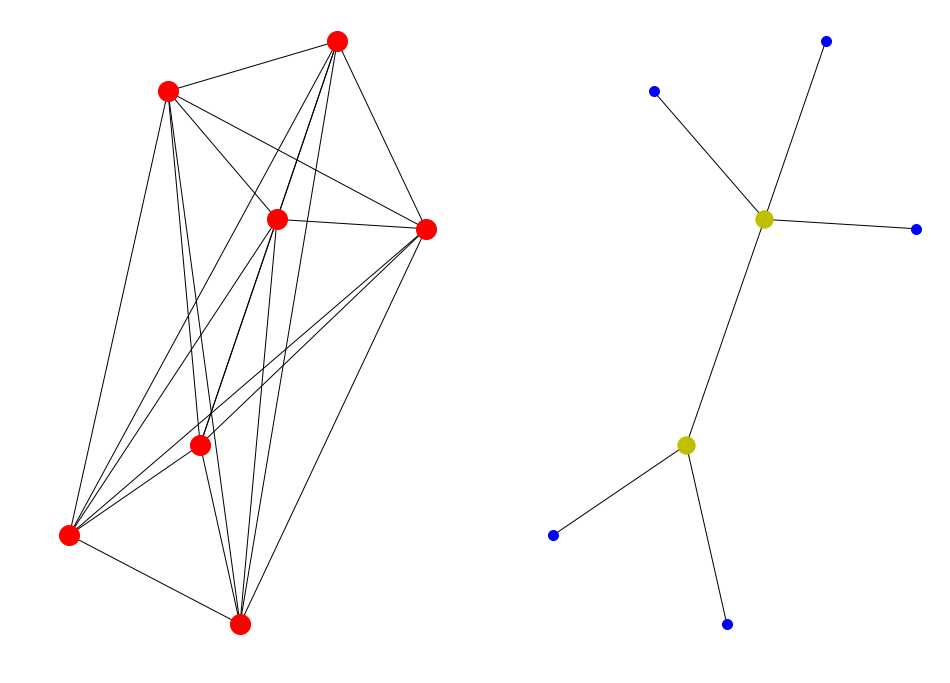

In [11]:
# Graphs, N = 7
ba = ba_model(N=7, m=1, threshold=1.5, seed=100)
ba.joint(path='Figures/network_types.png')

## BA examples of larger networks

Just playing around with the BA algorithm and our code

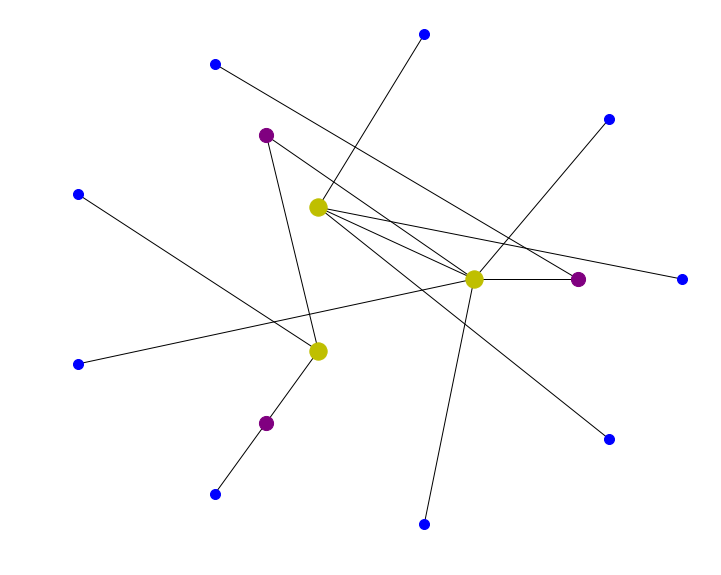

Each hub


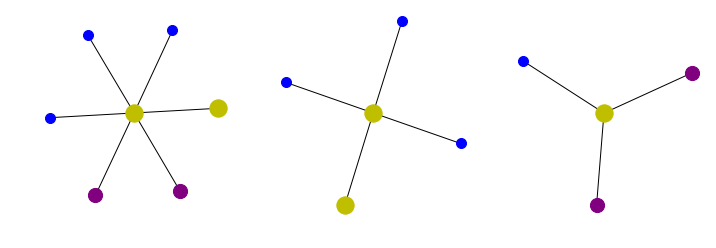

Each focus city


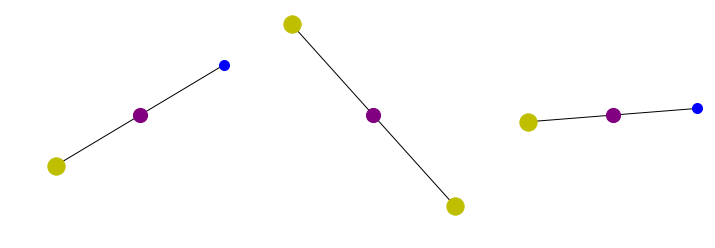

In [4]:
# Graphs, N = 15
ba = ba_model(N=15, m=1, threshold=1.5, seed=100)
ba.shell_b()
ba.hub()
ba.focus()

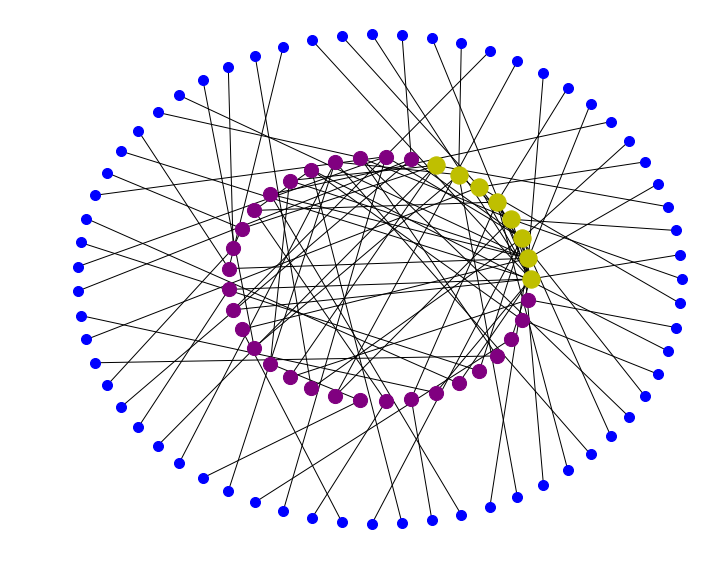

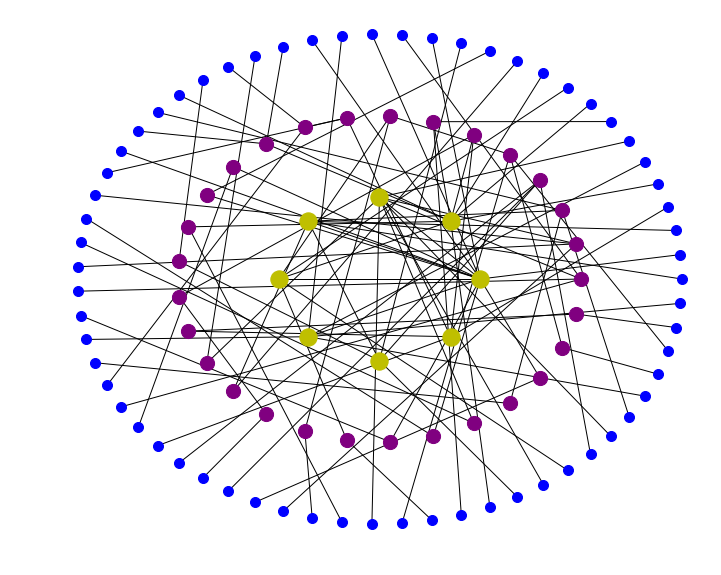

The 5 largest hubs of 8


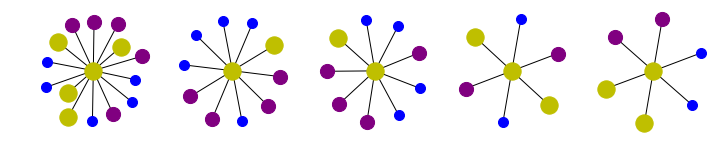

The 5 largest focus cities of 29


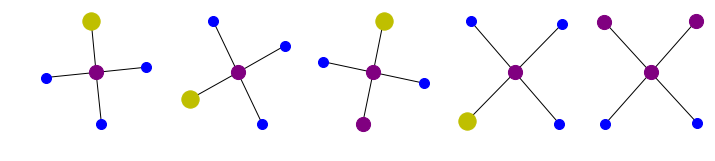

In [5]:
# Graphs, N = 100
ba = ba_model(N=100, m=1, threshold=2.5, seed=100)
# ba.draw()
ba.shell_a()
ba.shell_b()
ba.hub()
ba.focus()

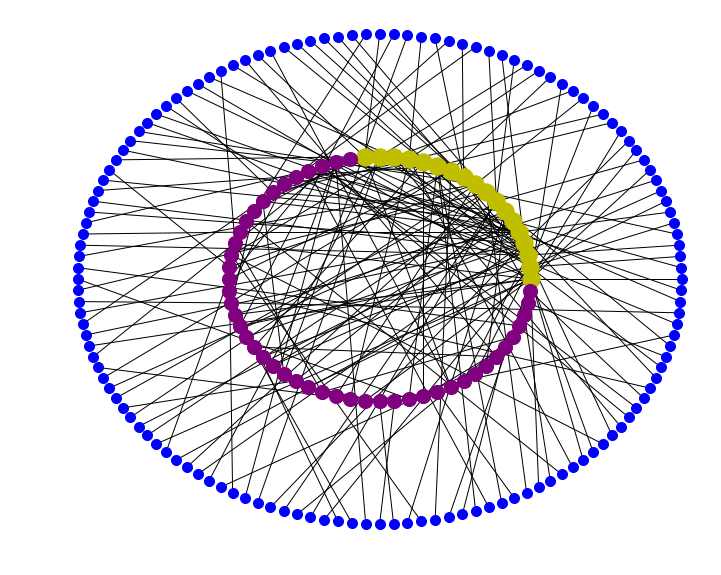

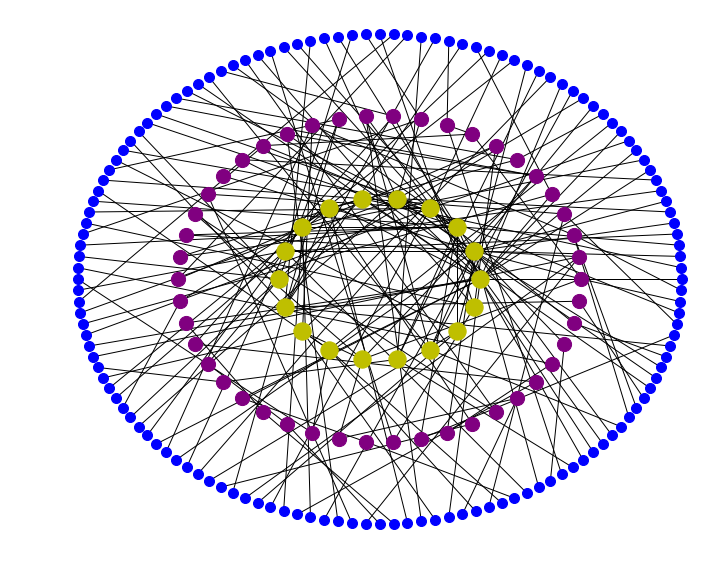

The 5 largest hubs of 18


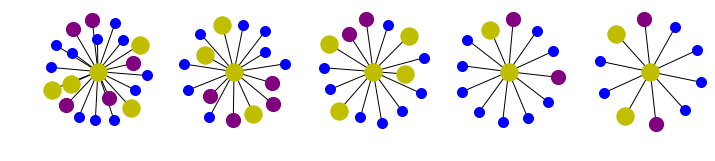

The 5 largest focus cities of 46


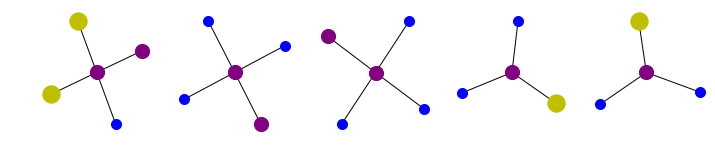

In [6]:
# Graphs, N = 200
ba = ba_model(N=200, m=1, threshold=2.5, seed=100)
# ba.draw()
ba.shell_a()
ba.shell_b()
ba.hub()
ba.focus()